## Regression Decision Tree

Regression Decision Trees are non-parameterized, supervised machine learning algorithms that essentially asks the dataset questions. The goal of these questions is to split the data into similar groups, where from there a prediction of the average target value would be accurate.

RDTs are great because they are easy to interpret and visualize. Furthermore, they can handle non-linear relationships.

However, the unrestrained objective of isolating samples leads to overfitting, meaning deep trees and sensitivity to small changes in data. Using hyperparameters such as min samples and max depth and techniques like pruning can constrain the model and promote generalizability.

The model works by choosing a feature and split that minimizes the variance on both sides of the split. This objective ensures the samples within the subsets are as similar as possible.

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk

from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor, plot_tree


In [2]:
class Node:

        def __init__(self, left, right, feature, threshold, avg_target, sse=0):
            
            self.left = left
            self.right = right
            self.feature = feature
            self.threshold = threshold
            self.avg_target = avg_target
            self.sse = sse


class RegressionDecisionTree:

    def __init__(self, min_samples=5, max_depth=3):

        self.min_samples = min_samples if min_samples > 0 else 5
        self.max_depth = max_depth if max_depth > 1 else 3
        self.root = None
    
    def get_sse(self, subset, target_col):

        return sum((subset[target_col] - subset[target_col].mean())**2)

    
    def fit(self, data, target_col):

        self.root = self._fit(0, data, target_col, float("inf"))
    
    def _fit(self, depth, data, target_col, parent_sse):
         
        if len(data) < self.min_samples or depth >= self.max_depth:
             
            return Node(None, None, None, None, data[target_col].mean())

        features = [f for f in data.columns if f != target_col]

        best_feat, best_split, best_sse = None, None, parent_sse

        for feat in features:
             
            sorted_data = data.sort_values(by=[feat], ascending=True)
            uniques = np.unique(sorted_data[feat])


            for i in range(1, len(uniques)):

                split = (uniques[i-1] + uniques[i]) / 2

                left_region = data[data[feat] < split]
                right_region = data[data[feat] >= split]

                total_sse = self.get_sse(left_region, target_col) + self.get_sse(right_region, target_col)

                if total_sse < best_sse:

                    best_feat, best_split = feat, split
                    best_sse = total_sse
        
        if not best_feat:

            return Node(None, None, None, None, data[target_col].mean())

        node = Node(None, None, best_feat, best_split, data[target_col].mean(), best_sse)
        print(f"Node best feat: {node.feature}, Node best split: {node.threshold}, Node average target: {node.avg_target}, Node best sse: {best_sse}")
        node.left = self._fit(depth+1, data[data[best_feat] < best_split], target_col, best_sse)
        node.right = self._fit(depth+1, data[data[best_feat] >= best_split], target_col, best_sse)
        return node

    def predict(self, data):

        preds = [self._predict(row[1]) for row in data.iterrows()]
        return np.array(preds)

    
    def _predict(self, obs):

        curr = self.root

        while curr.left and curr.right:

            feat, split = curr.feature, curr.threshold

            if obs[feat] < split:

                curr = curr.left
            
            else:

                curr = curr.right
        
        return curr.avg_target


         


In [3]:
def mse(y_true, y_hat):

    return np.mean((y_true - y_hat)**2)

def rmse(y_true, y_hat):

    return np.sqrt(np.mean((y_true - y_hat)**2))



In [4]:
np.random.seed(42)

diabetes = load_diabetes(as_frame=True, scaled=False)
target = "target"

data = diabetes["data"]
data[target] = diabetes[target]


train_size = 0.8

train_data = data[:int(len(data)*train_size)]
test_data = data[int(len(data)*train_size):]

print("Train Data Shape", train_data.shape)
print("Test Data Shape", test_data.shape)


Train Data Shape (353, 11)
Test Data Shape (89, 11)


In [5]:
data

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


In [6]:
max_depth, min_samples = 6, 5

my_rdt = RegressionDecisionTree(min_samples=min_samples, max_depth=max_depth)
my_rdt.fit(train_data, target)

sklearn_rdt = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples)
y = train_data[target]
X = train_data.drop(columns=target)
y_test = test_data[target]
X_test = test_data.drop(columns=target)
sklearn_rdt.fit(X, y)




Node best feat: s5, Node best split: 4.824299999999999, Node average target: 151.4787535410765, Node best sse: 1419688.7013078826
Node best feat: bmi, Node best split: 26.95, Node average target: 120.6086956521739, Node best sse: 672801.3384121892
Node best feat: s3, Node best split: 55.5, Node average target: 104.33720930232558, Node best sse: 382472.96665282984
Node best feat: s1, Node best split: 240.5, Node average target: 117.5050505050505, Node best sse: 266559.2422680413
Node best feat: s5, Node best split: 4.174300000000001, Node average target: 114.94845360824742, Node best sse: 250539.31500000006
Node best feat: bmi, Node best split: 23.25, Node average target: 93.32, Node best sse: 44521.28571428571
Node best feat: s2, Node best split: 87.19999999999999, Node average target: 122.45833333333333, Node best sse: 184036.84999999998
Node best feat: s3, Node best split: 98.5, Node average target: 86.47945205479452, Node best sse: 77457.6527777778
Node best feat: bp, Node best spli

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_le

In [7]:
rdt_preds = my_rdt.predict(test_data)
sklearn_preds = sklearn_rdt.predict(X_test)

pd.DataFrame(data={"Mean squared Error": [mse(test_data[target], rdt_preds), mse(y_test, sklearn_preds)] , "Root Mean Squared Error": [rmse(test_data[target], rdt_preds), rmse(y_test, sklearn_preds)]}, index=["My RDT", "SKlearn RDT"])



,Mean squared Error,Root Mean Squared Error
My RDT,4564.257823,67.559291
SKlearn RDT,4626.814705,68.020693


[Text(0.574468085106383, 0.9285714285714286, 'x[8] <= 4.824\nsquared_error = 5803.74\nsamples = 353\nvalue = 151.479'),
 Text(0.3191489361702128, 0.7857142857142857, 'x[2] <= 26.95\nsquared_error = 3710.377\nsamples = 230\nvalue = 120.609'),
 Text(0.4468085106382979, 0.8571428571428572, 'True  '),
 Text(0.19148936170212766, 0.6428571428571429, 'x[6] <= 55.5\nsquared_error = 2458.828\nsamples = 172\nvalue = 104.337'),
 Text(0.10638297872340426, 0.5, 'x[5] <= 176.8\nsquared_error = 3009.523\nsamples = 99\nvalue = 117.505'),
 Text(0.0851063829787234, 0.35714285714285715, 'x[8] <= 4.174\nsquared_error = 2745.307\nsamples = 97\nvalue = 114.948'),
 Text(0.0425531914893617, 0.21428571428571427, 'x[2] <= 23.25\nsquared_error = 2113.978\nsamples = 25\nvalue = 93.32'),
 Text(0.02127659574468085, 0.07142857142857142, 'squared_error = 2081.061\nsamples = 21\nvalue = 101.286'),
 Text(0.06382978723404255, 0.07142857142857142, 'squared_error = 204.75\nsamples = 4\nvalue = 51.5'),
 Text(0.127659574468

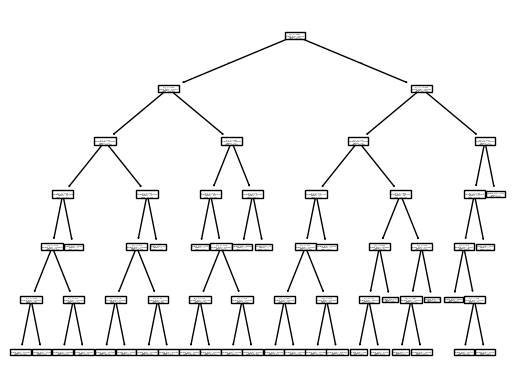

In [8]:
plot_tree(sklearn_rdt)